# Import data

In [573]:
import pandas
base_data_url = "../datasets/project/road safety/road-safety-data-{}"

In [574]:
accidents_16 = pandas.read_csv(base_data_url.format("accidents-2016.csv"))
accidents_15 = pandas.read_csv(base_data_url.format("accidents-2015.csv"))
accidents_14 = pandas.read_csv(base_data_url.format("accidents-2005-2014.csv"))

In [575]:
accidents = pandas.DataFrame()
accidents = pandas.concat([accidents_16, accidents_15, accidents_14], axis=0)

In [576]:
# accidents

# Investigate correlations
1. Are serious or fatal accidents more likely in bad weather?
2. Are serious or fatal accidents more likely during the night?
3. Do any times of day, days of week, or weeks of year have more serious or fatal accidents?

# 1: Bad weather
## Plotting

In [577]:
# Replace the weather with a number: 1 for bad weather, 0 for good
replacement_list = {'Fine + high winds': 1,
  'Fine no high winds': 0,
  'Fog or mist': 1,
  'Other': 0,
  'Raining + high winds': 1,
  'Raining no high winds': 1,
  'Snowing + high winds': 1,
  'Snowing no high winds': 1}

In [578]:
severities = ["Serious", "Slight", "Fatal"]

In [579]:
w_dict = {}
for severity in severities:
    w_dict[severity] = {}
    for weather_type in replacement_list.keys():
        matches = len(accidents[(accidents["Weather_Conditions"] == weather_type) &
                               (accidents["Accident_Severity"] == severity)])
        w_dict[severity][weather_type] = matches

In [580]:
# Plot results
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams["figure.figsize"] = (40,20)

d_serious = w_dict["Serious"]
d_slight = w_dict["Slight"]
d_fatal = w_dict["Fatal"]


In [581]:
def plot_wtype(wtype, title):
    plt.figure()
    plt.title = title
    plt.bar(range(len(wtype)), list(wtype.values()), align='center')
    plt.xticks(range(len(wtype)), list(wtype.keys()))
    plt.show()

In [582]:
#plot_wtype(d_fatal, "Fatal")

## Hypothesis testing
$H_0$: Prop(bad, (serious|fatal)) = Prop(bad, slight)


$H_1$: Prop(bad, (serious|fatal)) > Prop(bad, slight)

For a p-value of 0.05.

In [583]:
# Replace the weather
accidents["Weather_Bool"] = accidents["Weather_Conditions"].map(replacement_list)

In [584]:
slight_list = list(accidents[
    (accidents["Accident_Severity"] == "Slight")]
                   .Weather_Bool)

In [585]:
bad_list = list(accidents[
    (accidents["Accident_Severity"] == ("Serious" or "Fatal"))]
                   .Weather_Bool)

In [586]:
# Actually do the hypothesis test
from scipy.stats import ttest_ind
ttest_ind(slight_list, bad_list)

Ttest_indResult(statistic=1.1418463195447863, pvalue=0.25362583312719567)

p > 0.05, so the result is not significant and we accept the null hypothesis.

# 2: Night-time vs. daytime
$H_0$: Prop(serious, nighttime) = Prop(slight, nighttime)

$H_1$: Prop(serious, nighttime) > Prop(slight, nighttime)

p = 0.05.

In [587]:
accidents = pandas.concat([accidents, accidents_15, accidents_14], axis=0)

In [588]:
import datetime
from astral import Astral
city_name = 'Edinburgh'
a = Astral()
a.solar_depression = 'civil'
city = a[city_name]

def sun_at_day(day):
    sun = city.sun(date = day, local=False)
    return sun

def is_day(x):
    time_x = datetime.datetime.strptime(x + "+0000", '%d/%m/%Y %H:%M%z')
    sun = sun_at_day(time_x)
    
    
    if (sun['sunrise'] < time_x < sun['sunset']):
        return 0
    return 1

In [589]:
bad_accidents = accidents[(accidents["Accident_Severity"] == ("Serious" or "Fatal"))]
slight_accidents = accidents[(accidents["Accident_Severity"] == "Slight")]

In [590]:
bad_dt = bad_accidents.Date + " " + bad_accidents.Time
slight_dt = slight_accidents.Date + " " + slight_accidents.Time

In [591]:
bad_dt = bad_dt.map(lambda x: is_day(x))
slight_dt = slight_dt.map(lambda x: is_day(x))

In [592]:
from scipy.stats import ttest_ind
ttest_ind(bad_dt, slight_dt)

Ttest_indResult(statistic=2.2383240618397853, pvalue=0.025244367725947698)

p < 0.05 so we reject the null hypothesis: the proportion of bad accidents during the night is greater than slight accidents during the night.

# 2.5: Darkness vs daytime


In [593]:
accidents = pandas.DataFrame()
accidents = pandas.concat([accidents_16, accidents_15, accidents_14], axis=0)

lights = {"Darkness - lights lit": 1,
         "Darkness - no lighting": 0,
         "Daylight": 1,
         "Darkness - lighting unknown": 0,
         "Darkness - lights unlit": 0}
accidents["Light_Bool"] = accidents["Light_Conditions"].map(lights)

In [594]:

bad_accidents = accidents[(accidents["Accident_Severity"] == ("Serious" or "Fatal"))]
slight_accidents = accidents[(accidents["Accident_Severity"] == "Slight")]


In [595]:
bad_l = list(bad_accidents["Light_Bool"])
slight_l = list(slight_accidents["Light_Bool"])

In [596]:
ttest_ind(bad_l, slight_l)

Ttest_indResult(statistic=-1.244340868497855, pvalue=0.21348926238999366)

# 3: Interesting times of day

In [597]:
import datetime

def hour(x):
    time_x = datetime.datetime.strptime(x, '%H:%M').time()
    hour_x = time_x.hour
    return hour_x

## Hour

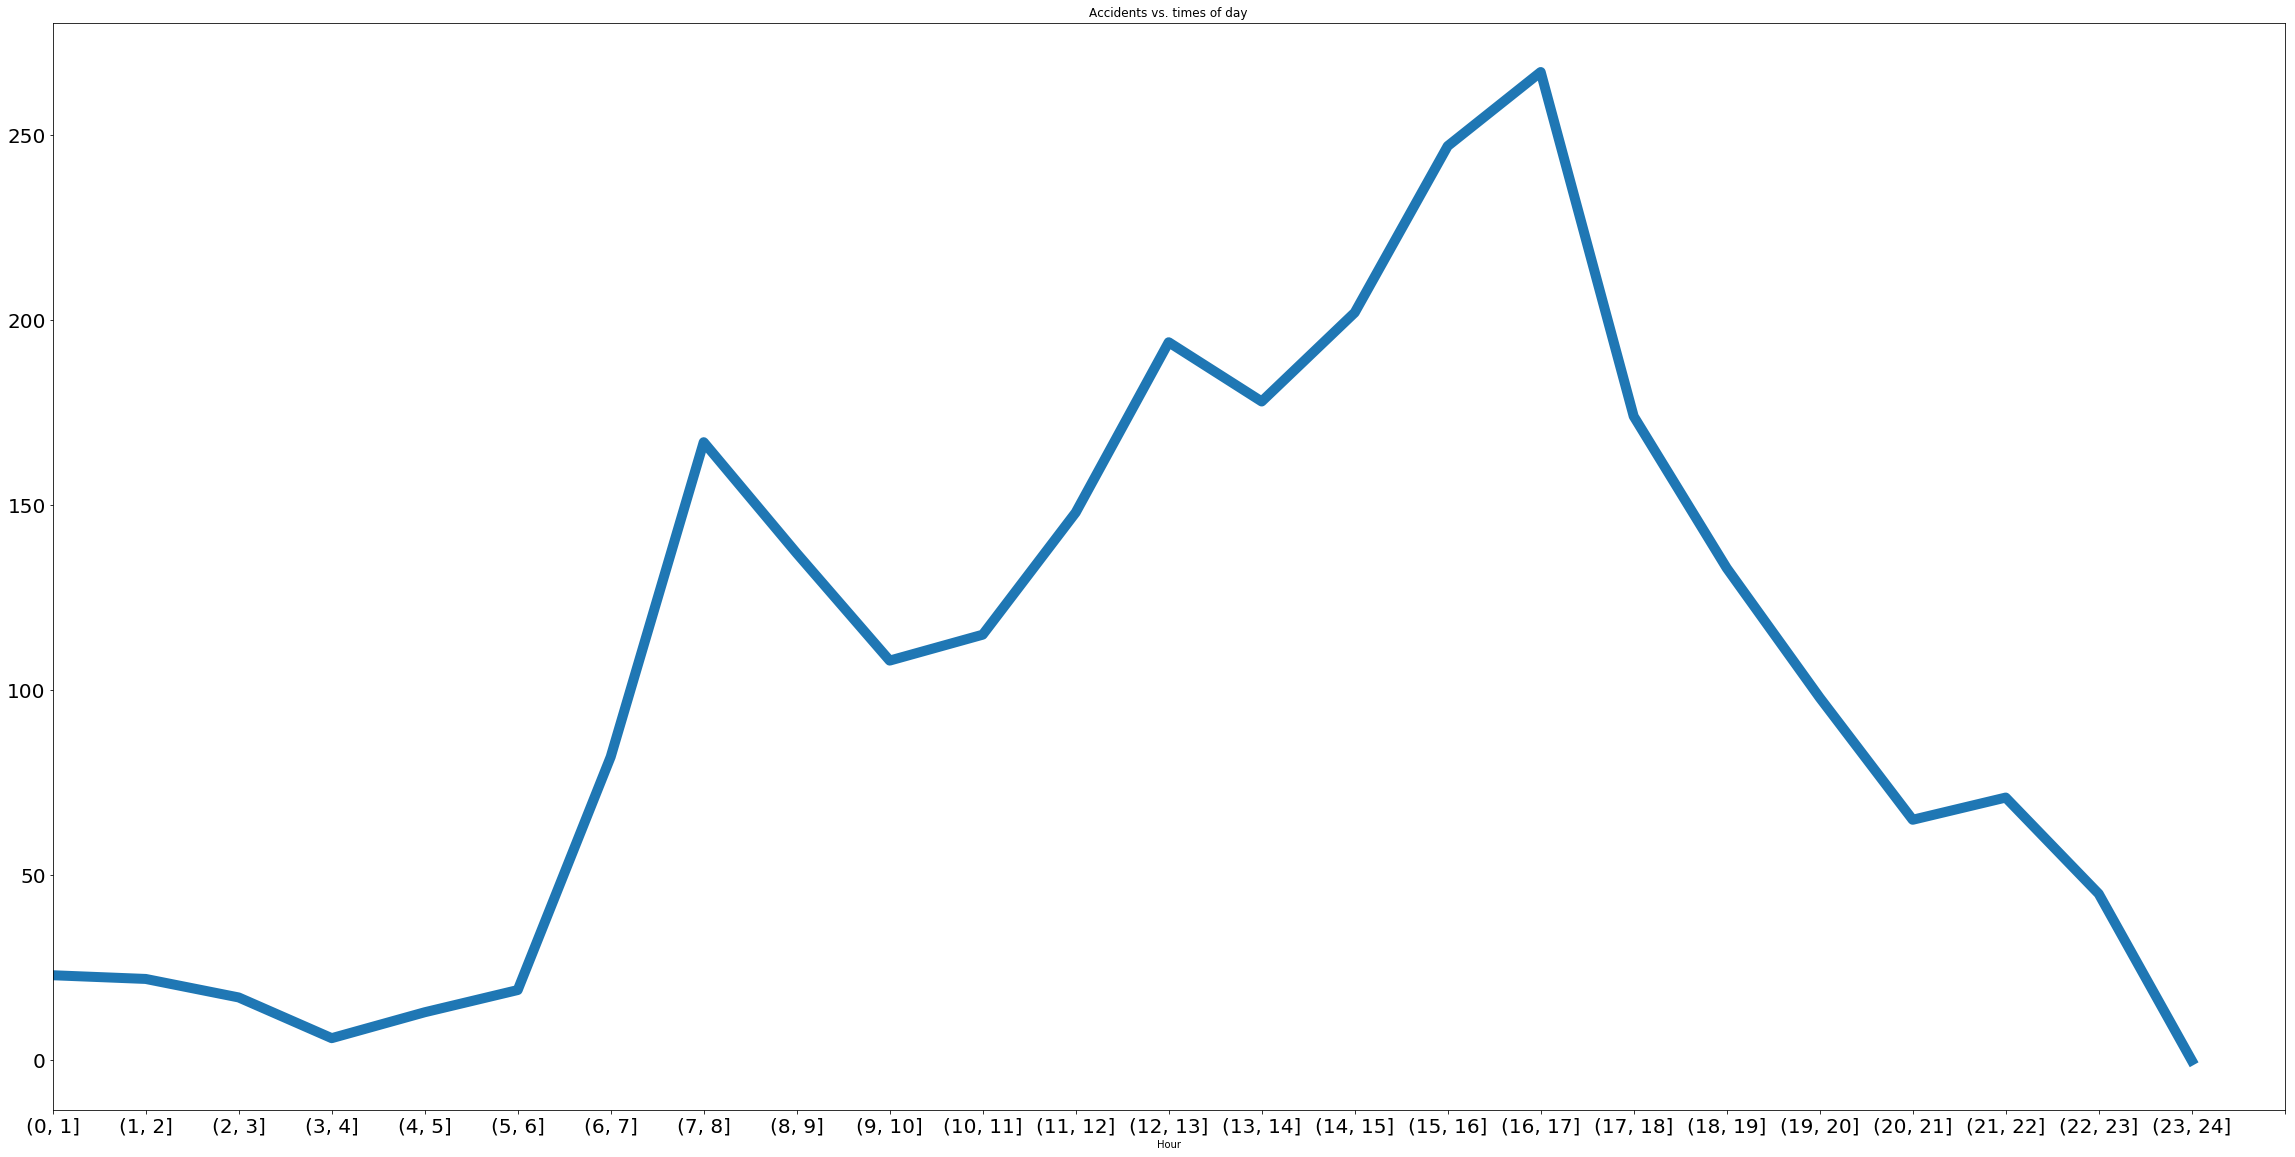

In [598]:
accidents["Hour"] = accidents.Time.map(lambda x: hour(x))
bins = [x for x in range(0, 25)]
s = accidents.groupby(pandas.cut(accidents['Hour'], bins=bins)).size()
s.plot(xticks=bins, linewidth=10, title="Accidents vs. times of day")
plt.show()

There are clear peaks at (7, 8] and (16, 17] - ie. the times that people commute to/from work. Also a smaller peak at (12, 13], lunchtime.

In [599]:
def month(x):
    month = datetime.datetime.strptime(x, '%d/%m/%Y').month
    return month

def year(x):
    year = datetime.datetime.strptime(x, '%d/%m/%Y').year
    return year

## Month

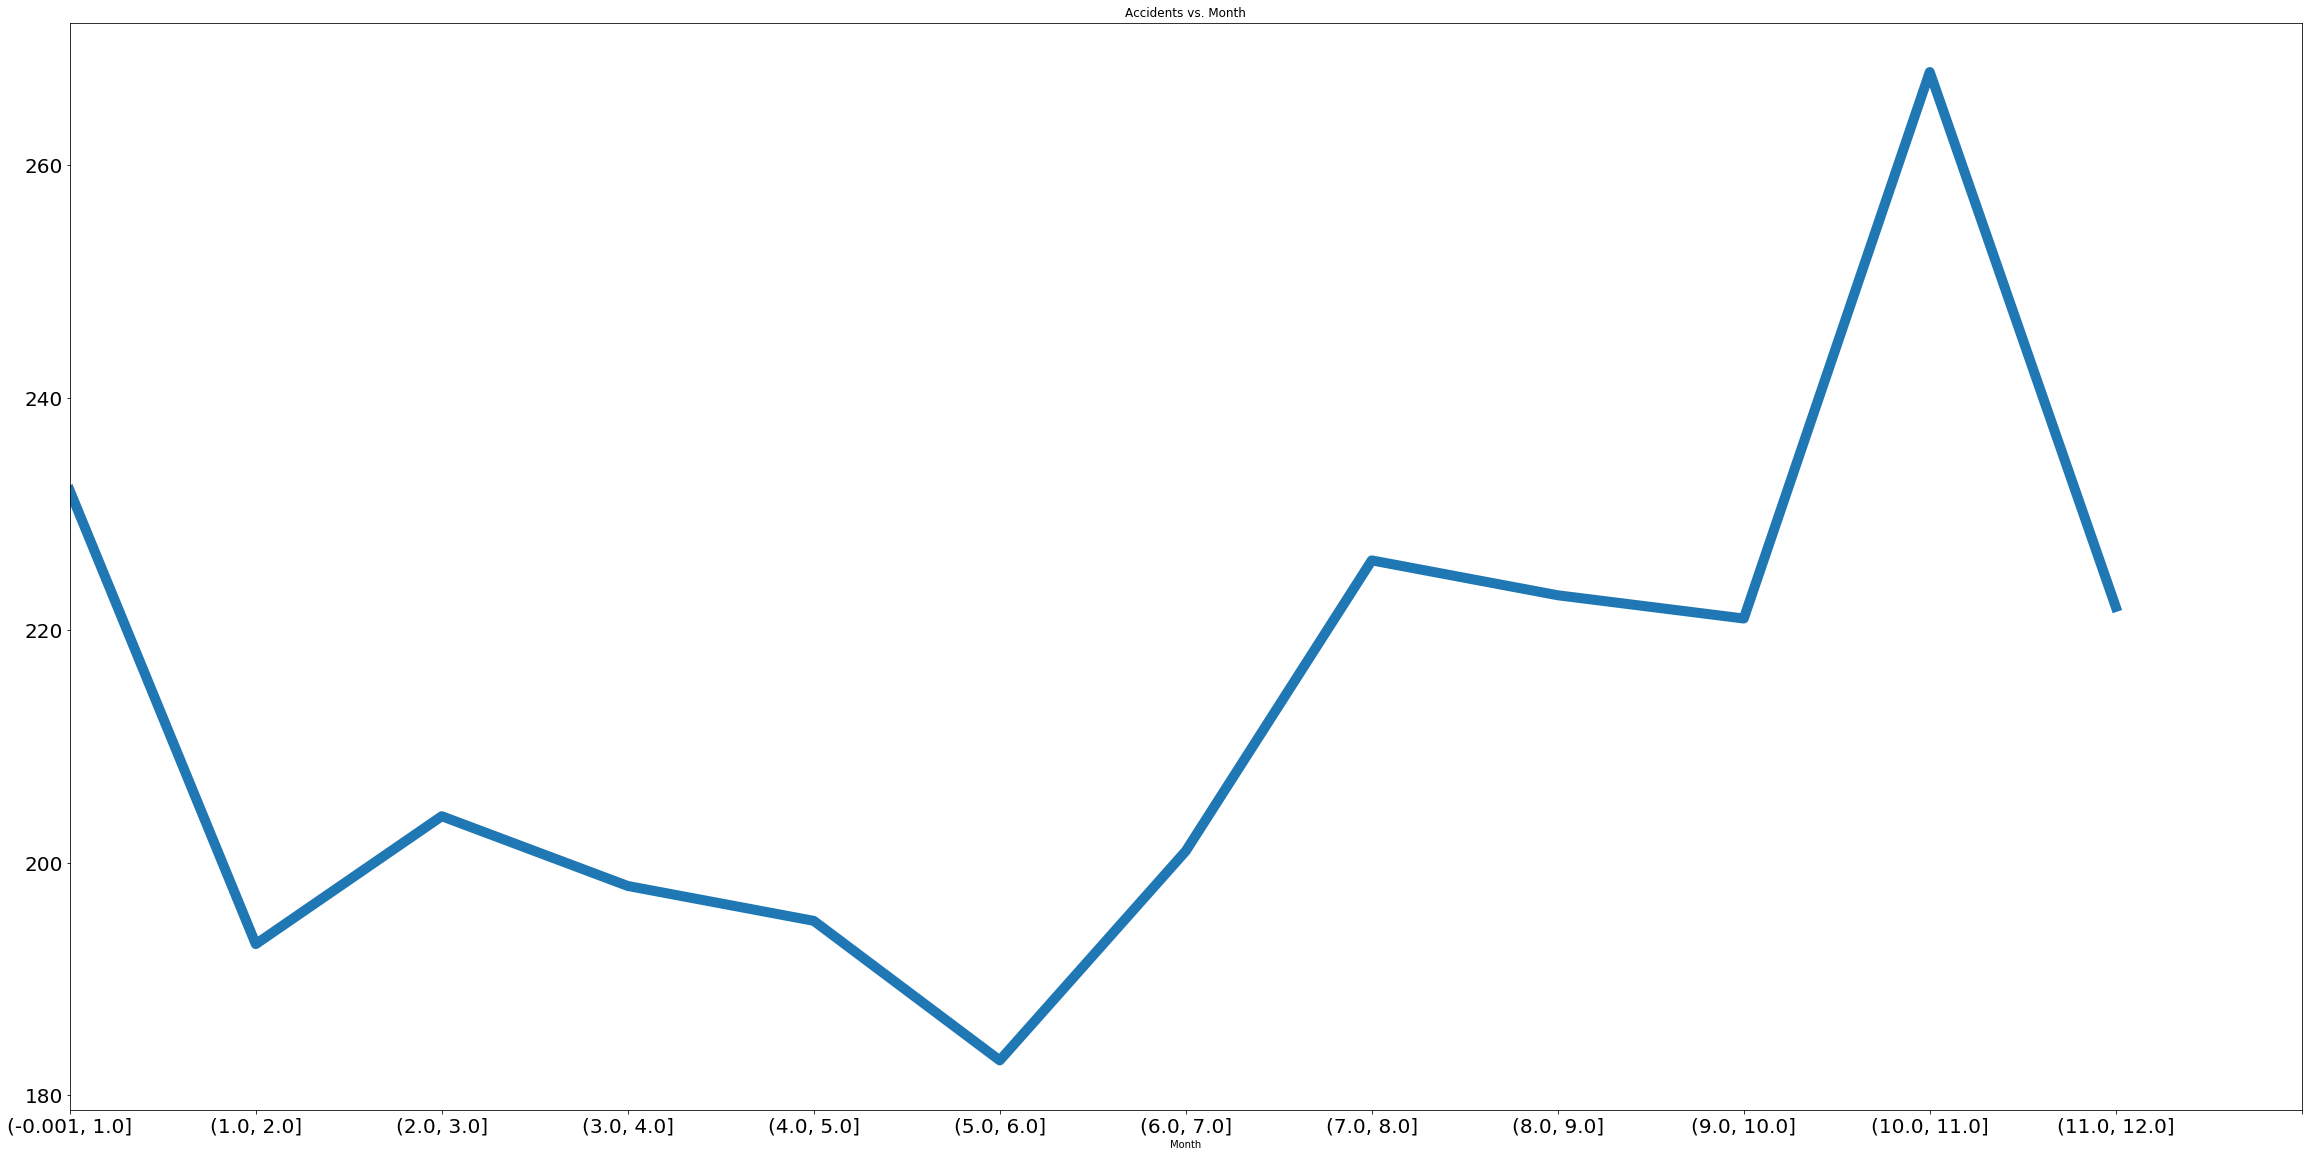

In [600]:
accidents["Month"] = accidents.Date.map(lambda x: month(x))
bins = [x for x in range(0, 13)]
s = accidents.groupby(pandas.cut(accidents['Month'], bins=bins, include_lowest=True)).size()
s.plot(xticks=bins, title="Accidents vs. Month", linewidth=10)
plt.show()

More accidents in winter months - probably due to road conditions.

## Year

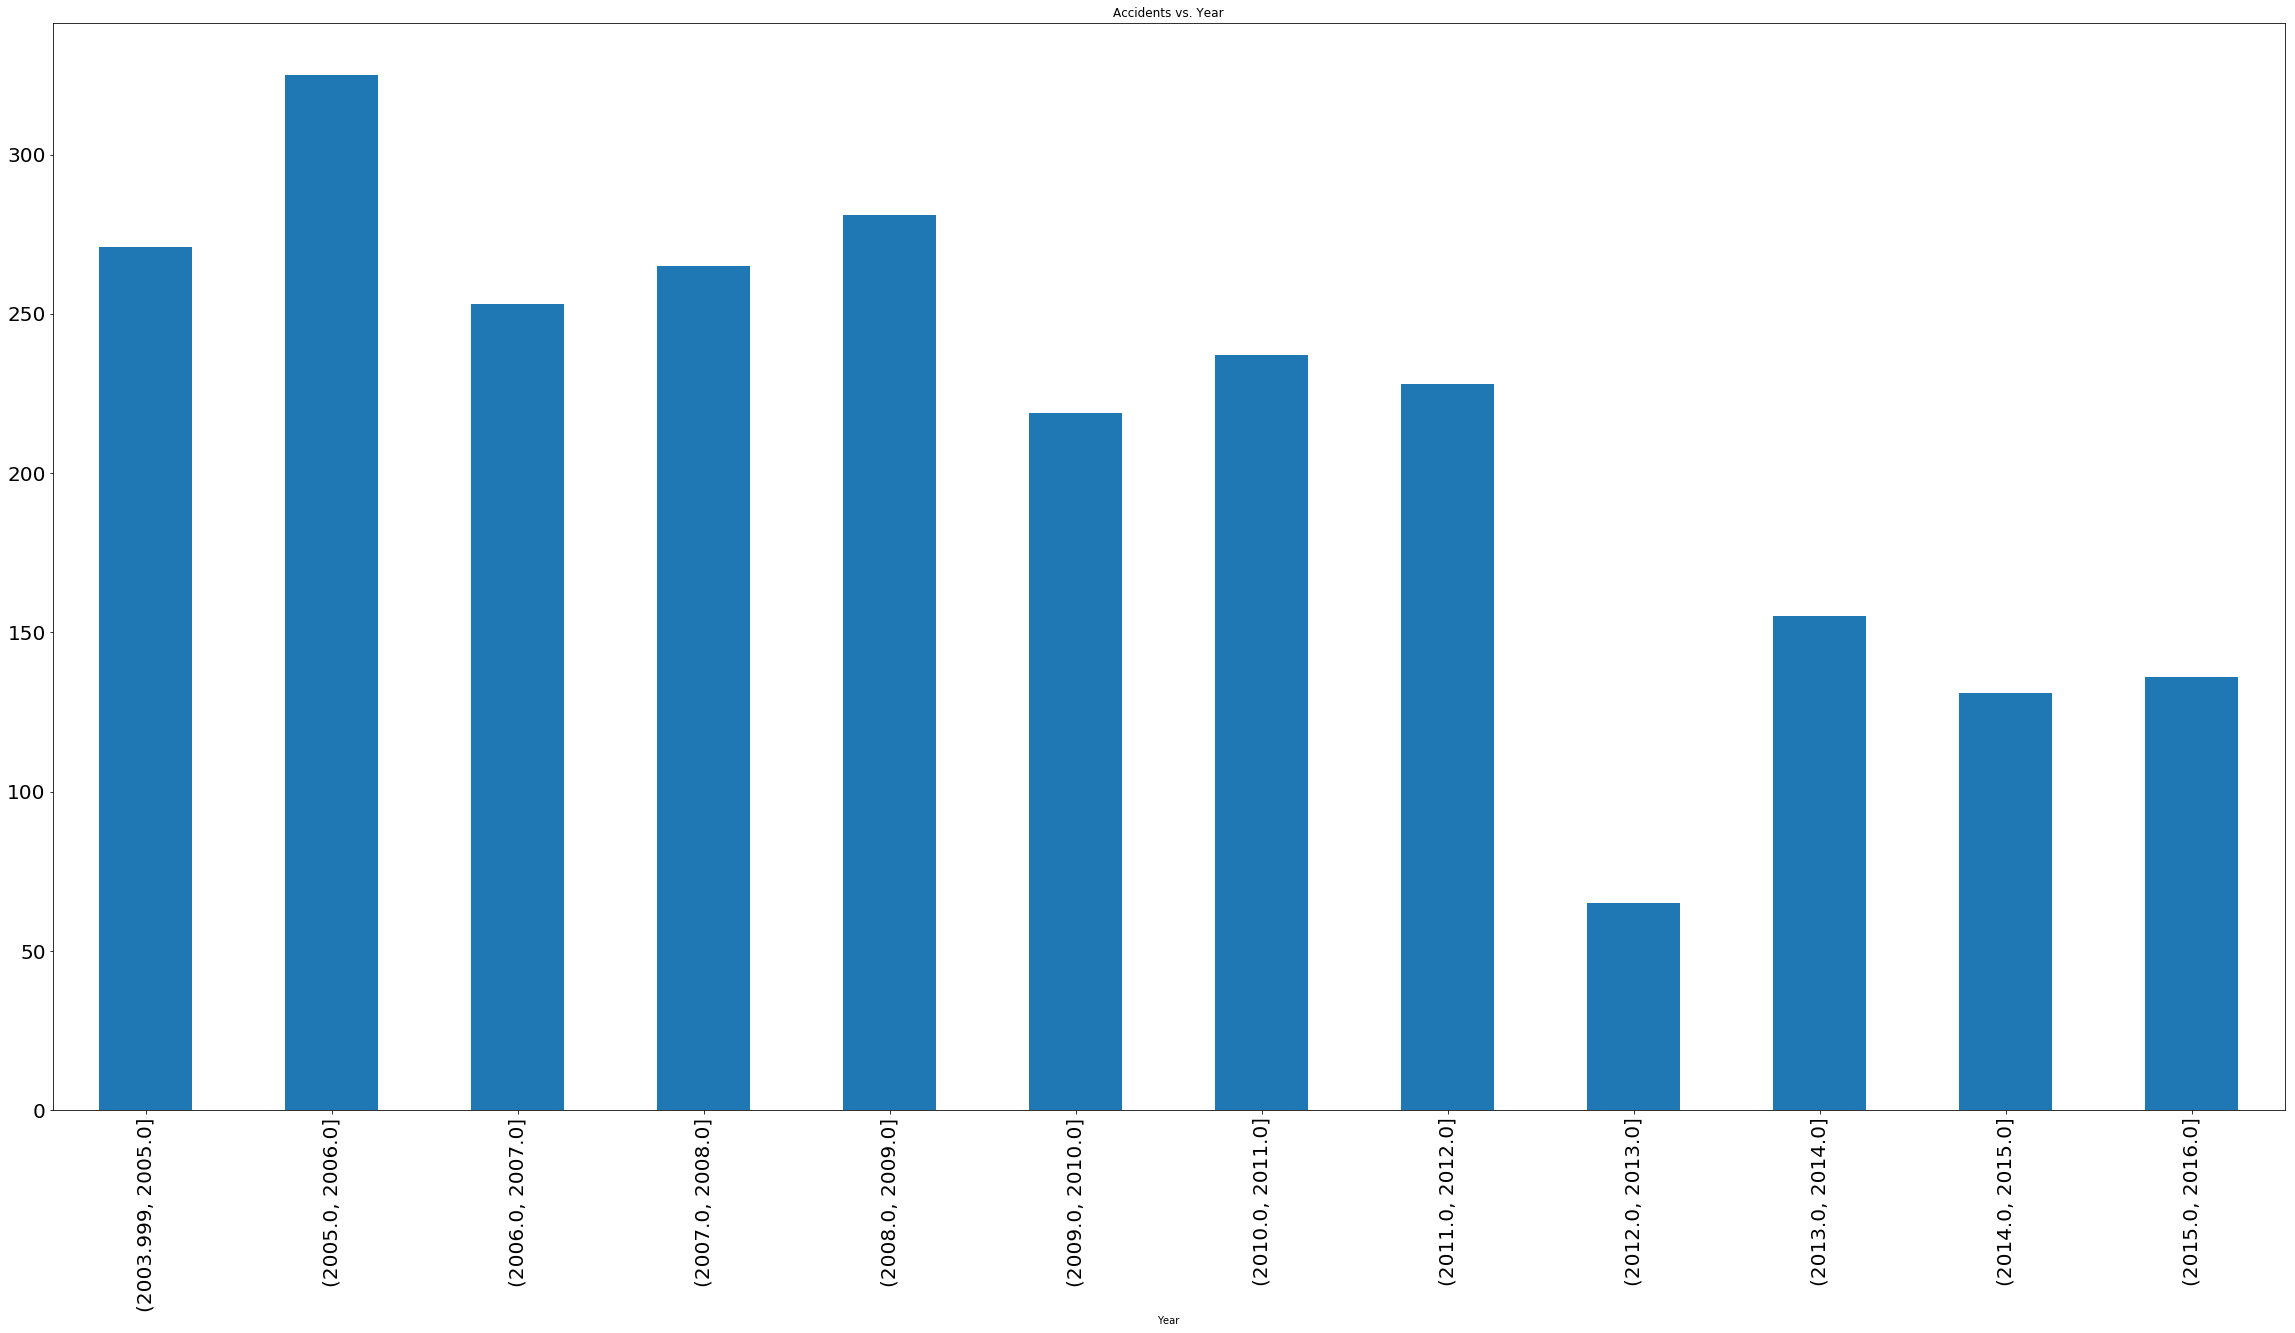

In [601]:
accidents["Year"] = accidents.Date.map(lambda x: year(x))
bins = [x for x in range(2004, 2017)]
s = accidents.groupby(pandas.cut(accidents['Year'], bins=bins, include_lowest=True)).size()
s.plot(title="Accidents vs. Year", kind="bar")
plt.show()

## Day 

In [602]:
def day(x):
    day = datetime.datetime.strptime(x, '%d/%m/%Y').weekday()
    return day

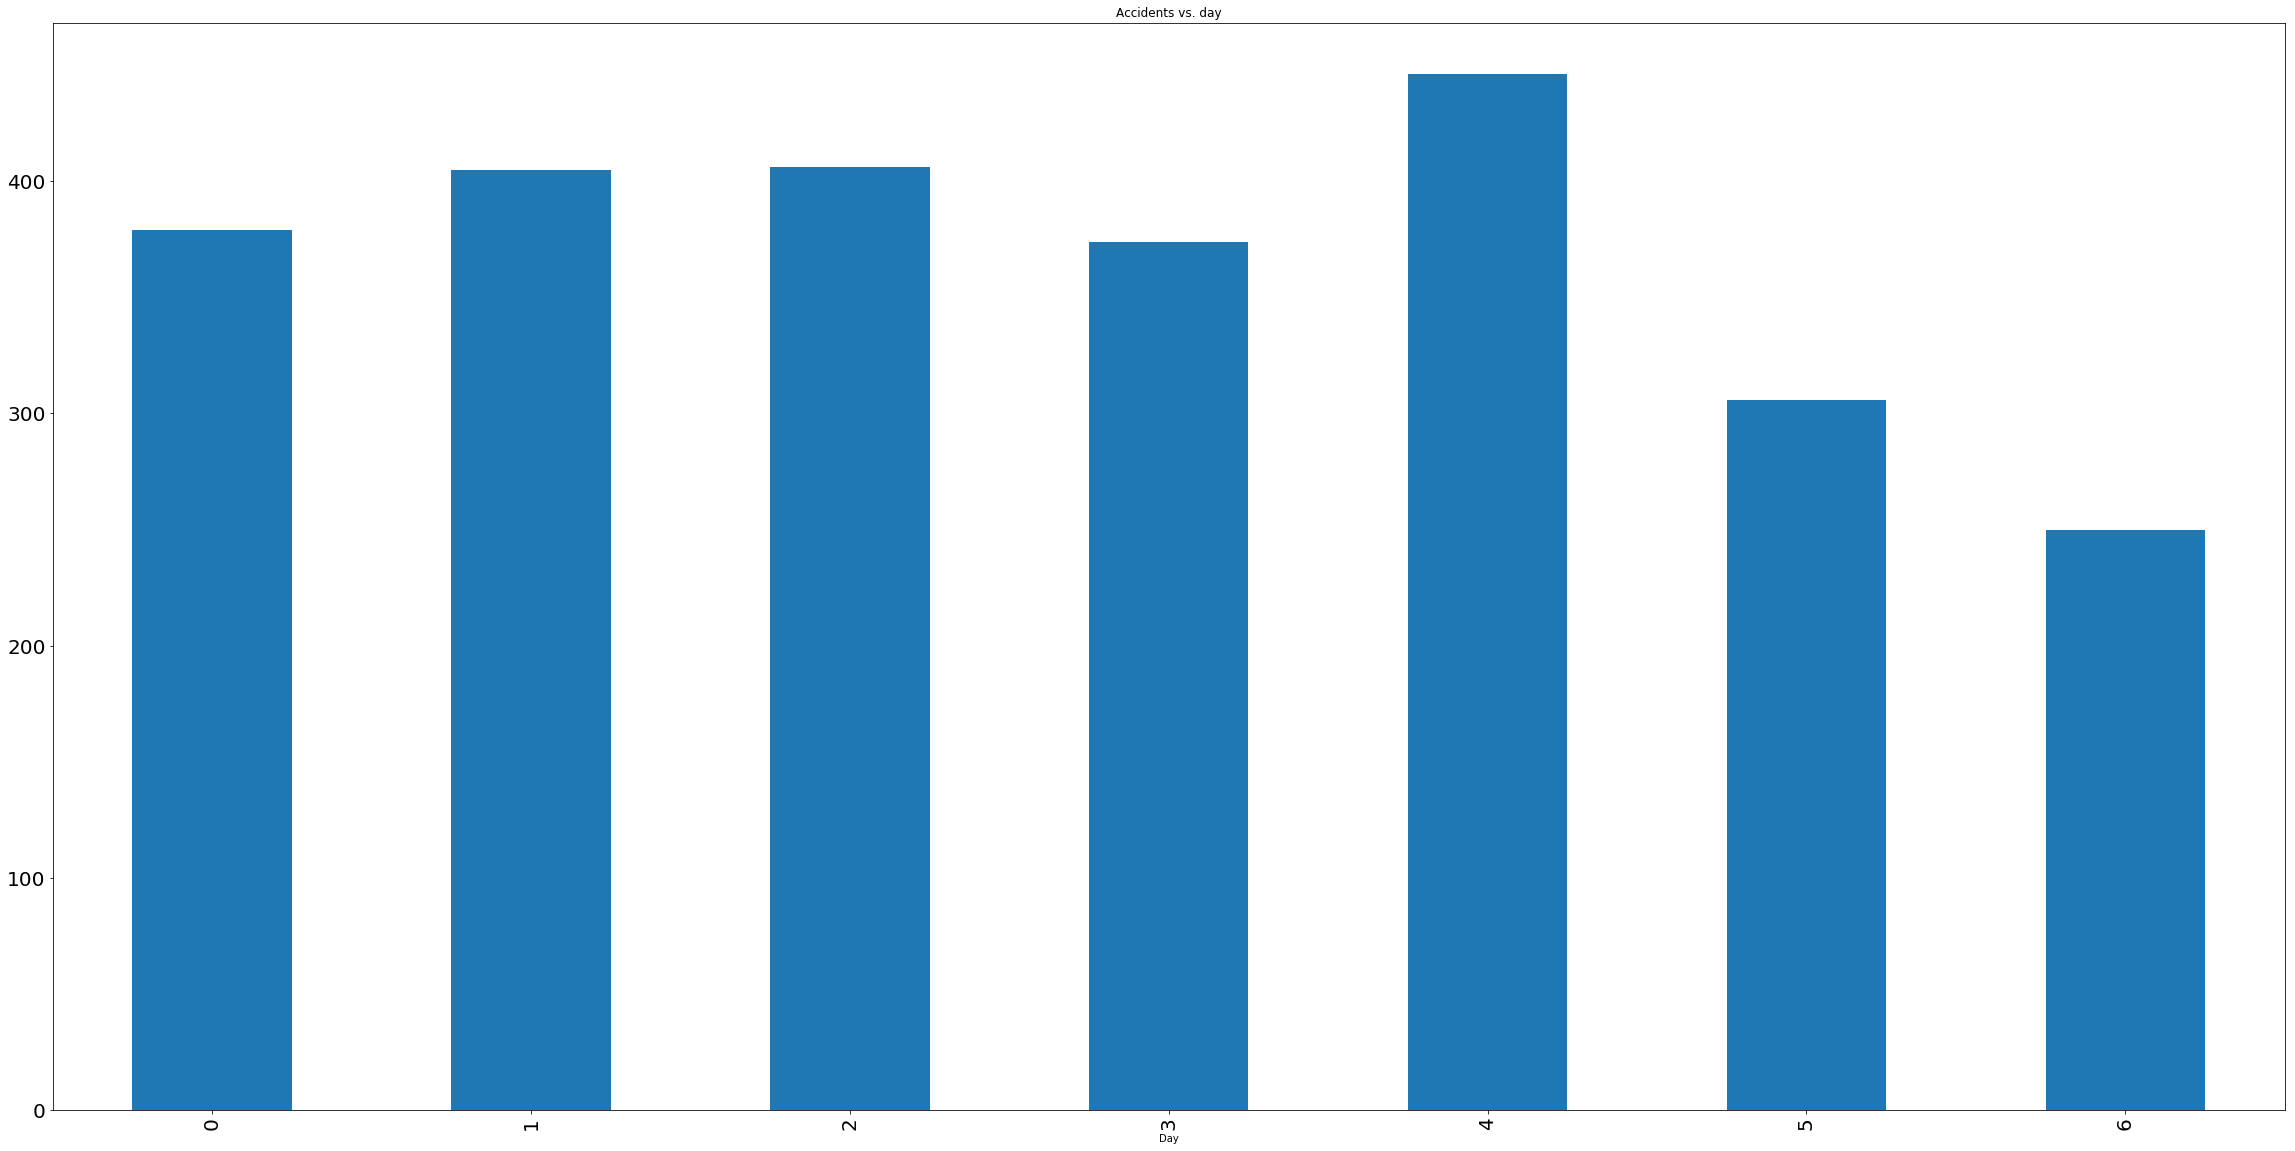

In [603]:
accidents["Day"] = accidents.Date.map(lambda x: day(x))
bins = [x for x in range(0, 7)]
s = accidents.groupby("Day").count()
s_idx = s["Accident_Index"]
s_idx.plot(kind="bar", title="Accidents vs. day")
plt.show()

# Pretty plots

In [604]:
import folium

In [605]:
accidents = pandas.DataFrame()
accidents = pandas.concat([accidents_16, accidents_15, accidents_14], axis=0)

accidents_n = accidents.loc[(accidents["Latitude"] != "Data missing or out of range") &
             (accidents["Longitude"] != "Data missing or out of range")]
# Convert lat/long fields to numeric, or we have a crash
accidents_n[['Longitude','Latitude']] = accidents_n[['Longitude','Latitude']].apply(pandas.to_numeric)

/usr/lib64/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [606]:
map_acc = folium.Map(location=[56.4620, -2.9707], zoom_start=12)
colors = {'Slight': 'green', 'Serious': 'orange', 'Fatal': 'red'}
accidents_n.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                               radius=10, 
                                               fill_color=colors[row["Accident_Severity"]],
                                               fill = True,
                                               stroke=False,
                                               fill_opacity=0.5)
                                             .add_to(map_acc), axis=1)

map_acc.save("map_acc.html")

In [607]:
import numpy
cameras = pandas.read_csv("../datasets/project/cameras_wgs.csv", delimiter='\t')
# Need to filter out nans here
cameras = cameras[numpy.isfinite(cameras['Lat'])]

In [608]:
cameras_coords = pandas.concat([cameras.Lat, cameras.Lon], axis=1)

In [609]:
def notnan(x):
    try: 
        int(x)
        return True
    except:
        return False

In [610]:
from scipy.spatial import Voronoi, voronoi_plot_2d
cameras_list = [list(x) for x in cameras_coords.values if notnan(x[0])]

vor = Voronoi(cameras_list) 

In [611]:
%%capture
# Now actually plot with folium
map_cam = folium.Map(location=[56.4620, -2.9707], zoom_start=12)

cameras.apply(lambda row:folium.Circle(location=[row["Lat"], row["Lon"]], 
                                       radius=1, 
                                       color='black',
                                       popup = row["Camera Location"])
                                      .add_to(map_cam), axis=1)

In [612]:
# Add voronois
# http://comet.lehman.cuny.edu/owen/teaching/datasci/makeVor.py

from geojson import FeatureCollection, Feature, Polygon

vorJSON = open('libVor.json', 'w')
point_voronoi_list = []
feature_list = []
for region in range(len(vor.regions)-1):
    vertex_list = []
    for x in vor.regions[region]:
        #Not sure how to map the "infinite" point, so, leave off those regions for now:
        if x == -1:
            break;
        else:
            #Get the vertex out of the list, and flip the order for folium:
            vertex = vor.vertices[x]
            vertex = (vertex[1], vertex[0])
        vertex_list.append(vertex)
    #Save the vertex list as a polygon and then add to the feature_list:
    polygon = Polygon([vertex_list])
    feature = Feature(geometry=polygon, properties={})
    feature_list.append(feature)

#Write the features to the new file:
feature_collection = FeatureCollection(feature_list)
print (feature_collection, file=vorJSON)
vorJSON.close()


folium.GeoJson(
    "libVor.json",
    name='geojson'
).add_to(map_cam)
map_cam.save("map_cam.html")

In [613]:
#map_cam

# Other stuff

## Food standards

In [614]:
food = pandas.read_csv("../datasets/fhrs.csv")
# Filter nans
food = food[numpy.isfinite(food["EstablishmentDetail - Geocode - Latitude"])]
# Make dataset smaller
#food = food.iloc[:100]

In [615]:
set(food["EstablishmentDetail - RatingValue"].values)

{'Awaiting Inspection', 'Exempt', 'Improvement Required', 'Pass'}

In [616]:
map_food = folium.Map(location=[56.4620, -2.9707], zoom_start=12)
colors = {'Awaiting Inspection': 'amber', 'Exempt': 'blue', 'Improvement Required': 'red', 'Pass': 'green'}
food.apply(lambda row:folium.CircleMarker(location=[row["EstablishmentDetail - Geocode - Latitude"], 
                                                    row["EstablishmentDetail - Geocode - Longitude"]],
                                         radius = 10,
                                         stroke = False,
                                         fill = True,
                                         fill_color = colors[row["EstablishmentDetail - RatingValue"]],
                                         fill_opacity = 0.5,
                                         )
                                             .add_to(map_food), axis=1)
map_food.save("map_food.html")

In [617]:
#map_food